In [ ]:
# %pip install -r requirements.txt

In [66]:
from options import Options
from grid import Grid
from trajectory_generator import generate_trajectory
import torch
import numpy as np
import plotting
import analysis
import os
%load_ext autoreload
import utils
import matplotlib.pyplot as plt
from train_RNN import TrainableNetwork, RNN_options, Trainer
%autoreload 2

SIM_PATH = os.getcwd() + '/sim_data/'

EXAMPLE_PATH = os.getcwd() + "/example_models/"  # Put interesting RNN of interest here
if not os.path.exists(EXAMPLE_PATH):
    os.mkdir(EXAMPLE_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Build and intiialize network

In [6]:
options = Options()
options.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device :', options.device)
grid = Grid(options)

device : cuda
Recovering pre-computed matrix found at /home/onyxia/work/grid_cells_burak_fiete/models/Wmat_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40.pth
Restoring pre-computed initial state found at /home/onyxia/work/grid_cells_burak_fiete/models/s0_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40_tau=0.01_alpha=0.2_tiling=deterministic_device=cuda_solver=euler_dt=0.0001.pth


In [17]:
u, s, vh = np.linalg.svd(grid.W.cpu())

(0.0, 50.0)

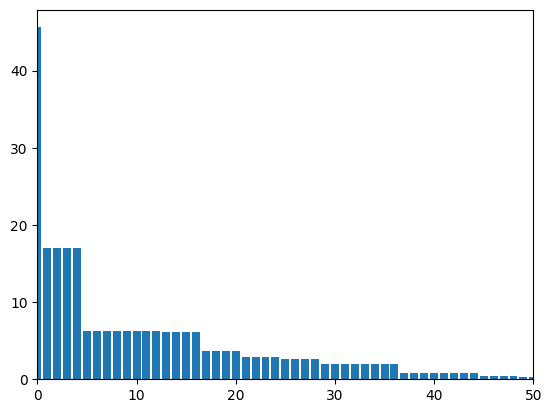

In [27]:
plt.bar(range(len(s)), s)
plt.xlim(0, 50)

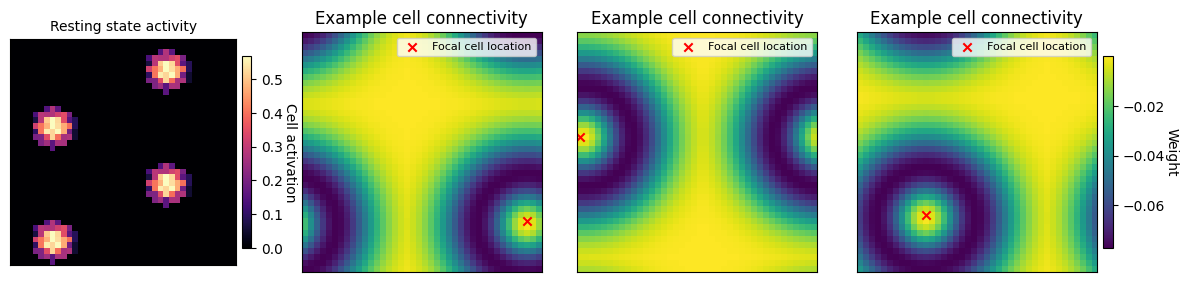

In [8]:
_ = plotting.network_presentation(grid)

### 2. Integrate random trajectory

Found pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/trajectory_len=100000_dt=0.0001_w=2.2_h=2.2_rotvelstd=1.6_meanv=0.8_border=0.03_borderslow=0.25.npy, loading it
loading pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/example_sim_T=10_dt=0.0001_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40_tau=0.01_alpha=0.2_tiling=deterministic_device=cuda_solver=euler_dt=0.0001.pth
labeling blobs


100%|██████████| 10000/10000 [00:00<00:00, 16195.74it/s]


detected less than 8 blobs per frame
computing blob centers


/opt/conda/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
100%|██████████| 10000/10000 [00:01<00:00, 6336.64it/s]


found 24 best blob jumps : interpolating speed between them
Estimated prediction to truth size ratio = 0.0643, R2=0.999


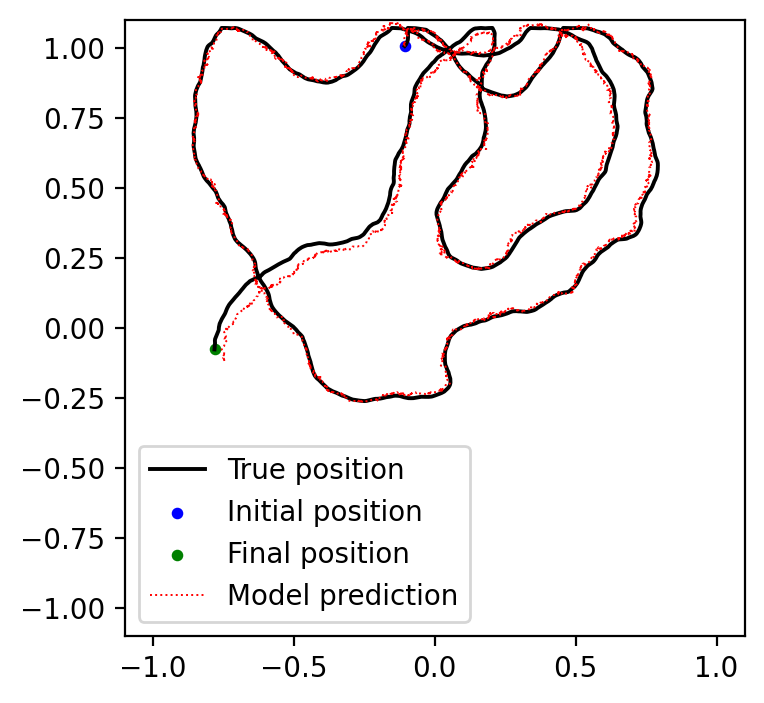

<Axes: >

In [9]:
# generate a trajectory 
box_width = box_height = 2.2 # m 
T = 10 # s
dt = grid.options.dt
seq_len = int(T/dt)

trajectory = generate_trajectory(box_width, box_height, seq_len, load=True, save=True, batch_size = 1, silent=False)

torch.cuda.empty_cache()
pos = np.stack([trajectory['target_x'].squeeze(), trajectory['target_y'].squeeze()], 1)
v_inputs = np.diff(pos, axis=0)/dt

fname = f"example_sim_T={T}_dt={dt}_{grid.grid_id}.pth"
grid.save_sim = True
S = grid.simulate(v_inputs, sim_id = fname, silent=False, load=True) # set load = false to restart a new sim from scratch

# downsample if needed for faster analysis 
new_dt = 1E-3
S = utils.downsample(S, new_dt=new_dt, old_dt = dt)
pos = utils.downsample(pos, new_dt=new_dt, old_dt = dt)

pos_pred, prop_factor, r2 = analysis.model_prediction(S, pos, verb = True)

plotting.compare_model_prediction(pos_pred, pos, box_width = box_width, box_height = box_height)

### Idées pour la suite :

- Entrainer un RNN (approche normative/optimale) cf https://github.com/ganguli-lab/grid-pattern-formation (publié sur Neuron, j'ai testé un peu l'approche et ca fonctionne, suffit de reprendre leur code ou de recoder une version + simple) => Comparer le résultat du RNN et du modele de burak

- Regarder la topologie du réseau (topologie torique ?) -> reduction de la dimensionalité de la matrice de connectivité et / ou de l'activité neuronale. Comparer eventuellement avec le RNN 

### 3. Normativity and optimisation : Train a RNN

We re-exploited recent work from [Sorscher *et al.* 2023](https://doi.org/10.1080/02786828708959166)

We adapted part of their [original code](https://github.com/ganguli-lab/grid-pattern-formation) for our simple use. In particular, grid cells patterns of activation were changed and new constraints were imposed to the model

In [48]:
rnn_opt = RNN_options()

rnn_opt.save_dir = os.getcwd() + '/models/'
rnn_opt.n_steps = 10000         # number of training steps
rnn_opt.batch_size = 200         # number of trajectories per batch
rnn_opt.sequence_length = 40     # number of steps in trajectory
rnn_opt.learning_rate = 1e-4     # gradient descent learning rate
rnn_opt.pc_sheet_size = 30      # sqrt of number of place cells 
rnn_opt.gc_sheet_size = 40       # sqrt of number of grid cells
rnn_opt.pc_sigma = 0.2

# width of place cell center tuning curve (m)
rnn_opt.activation = 'relu'      # recurrent nonlinearity
rnn_opt.weight_decay = 1e-4      # strength of weight decay on recurrent weights
rnn_opt.box_width = 2.2            # width of square arena 
rnn_opt.dt = 1E-2
rnn_opt.device = "cuda" if torch.cuda.is_available() else 'cpu'
rnn_opt.optim = 'adam'
rnn_opt.clip_grad = False
rnn_opt.debug = False

network = TrainableNetwork(rnn_opt,)
trainer = Trainer(network,  restore=False)

Initializing new model from scratch.
Saving to: /home/onyxia/work/grid_cells_burak_fiete/models/n_steps_10000_batch_size_200_sequence_length_40_learning_rate_0.0001_pc_sheet_size_30_gc_sheet_size_40_pc_sigma_0.2_activation_relu_weight_decay_0.0001_box_width_2.2_dt_0.01_optimizer_adam_device_cuda_clip_grad_False_optim_adam


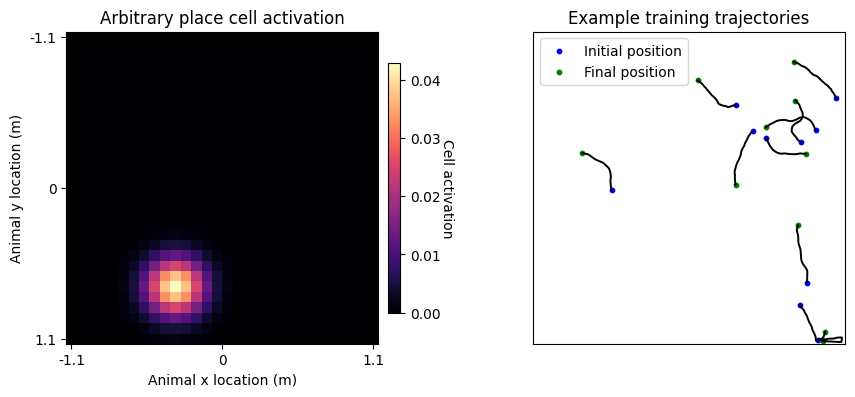

In [106]:
_ = plotting.present_training_environment(network, trainer, show=True)

In [ ]:
n_epochs = 2
trainer.train(n_epochs, rnn_opt.n_steps, plot=True)

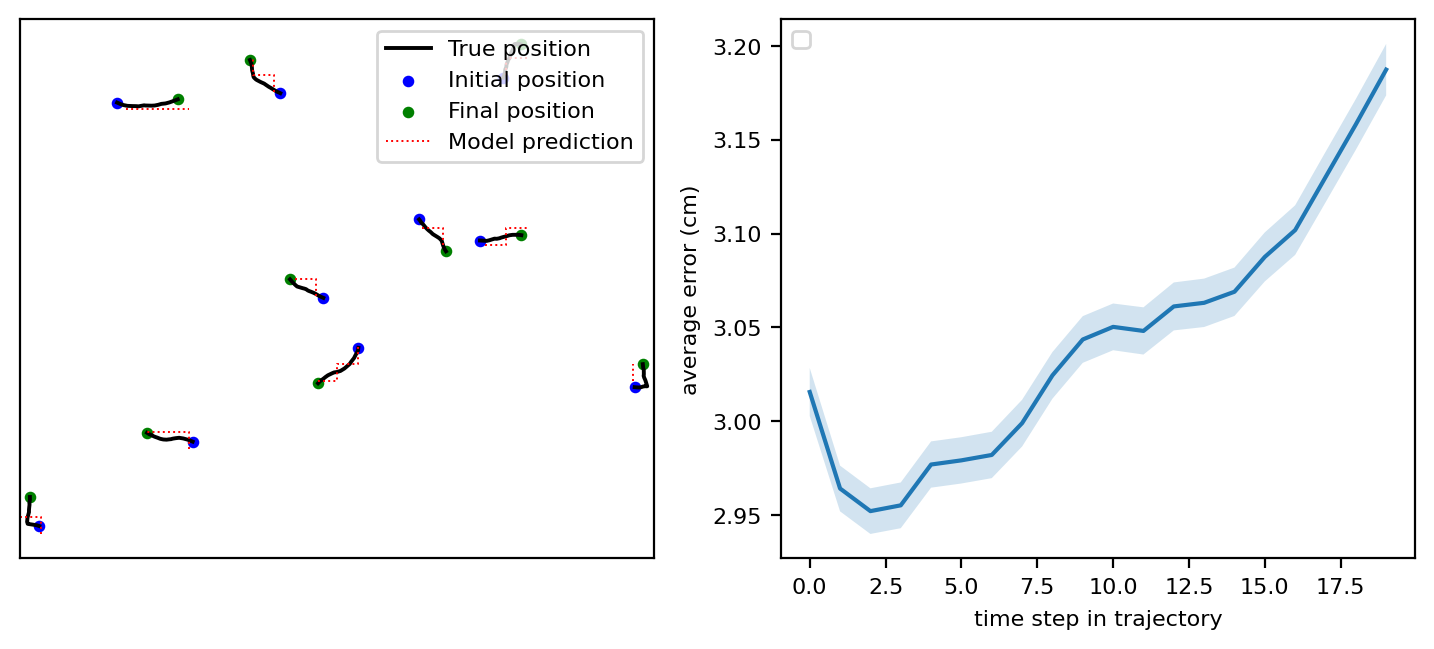

In [144]:
_ = plotting.show_training_results(trainer, network, show=True)

In [145]:
model_name = f"example_weight_decay={rnn_opt.weight_decay}_pc={rnn_opt.pc_sheet_size**2}_gc={rnn_opt.pc_sheet_size**2}_seqlen={rnn_opt.sequence_length}_no_other_reg.pth"
torch.save(network.state_dict(), EXAMPLE_PATH + model_name)

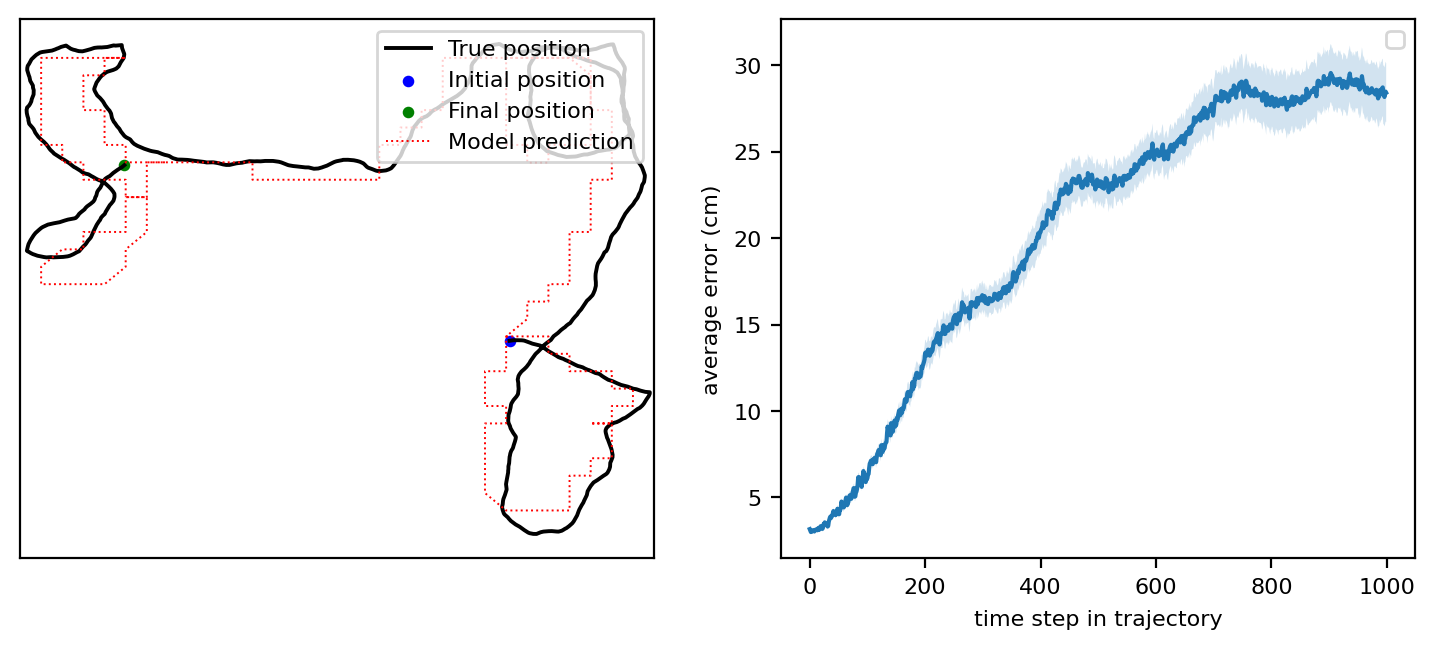

In [150]:
_ = plotting.show_training_results(trainer, network, show=True, sequence_length = 1000, plotted_trajectories = 1, num_trajectories = 100)

## 4. Evaluate performances of both approaches

# TODO :

### 1) Résultats principaux de l'article ->> Nicolas
- Faire une fonction qui montre le champ d'activation d'une grid cell, pour voir si l'activation est effectivement en grille
- Evaluer comment les erreurs se propagent au cours du temps cf figure 2 de l'article

### 2) RNN ->> Grégoire
- Voire si on peut améliorer la résolution spatiale des place cells
- Voire si on peut augmenter la taille de la séquence ( très courte pour l'instant et tester le modèle sur une grosse séquence )
- Utiliser les fonctions du **1)** pour evaluer le RNN - > comparer les modèles
- Ajouter des contraintes supplémentaires (contraintes sur l'activité "energetiques" en plus des contraintes sur les poids

### 3) Possibles suites
- Projection de l'activité des cellules dans un espace a faible dimension pour les deux réseaux -> voire les projections présentées dans la littérature
- Comparaison de la connectivité des cellules entre RNN et Burak-> Grégoire se renseigne la dessus
- Ondes theta et phase precession -> Nicolas si il a le temps

#### Avec ca on est très large en terme de contenu, largement au dessus des attentes du cours a mon avis ;)